<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

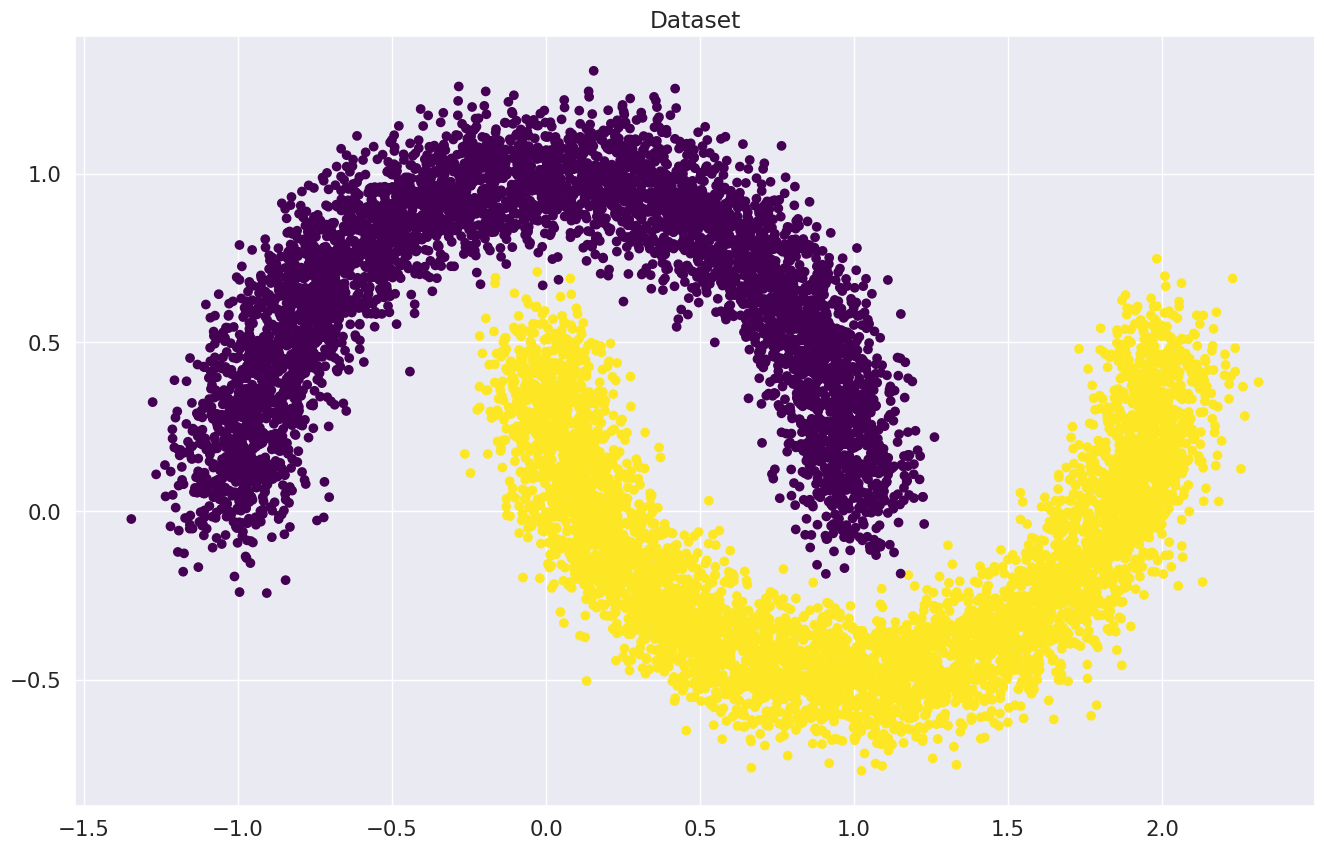

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)


Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True))

    def forward(self, x):
        x = x @ self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)

3

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.375
Iteration: 100
Batch accuracy: 0.7734375
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8828125
Iteration: 400
Batch accuracy: 0.859375
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 814

### Визуализируем результаты

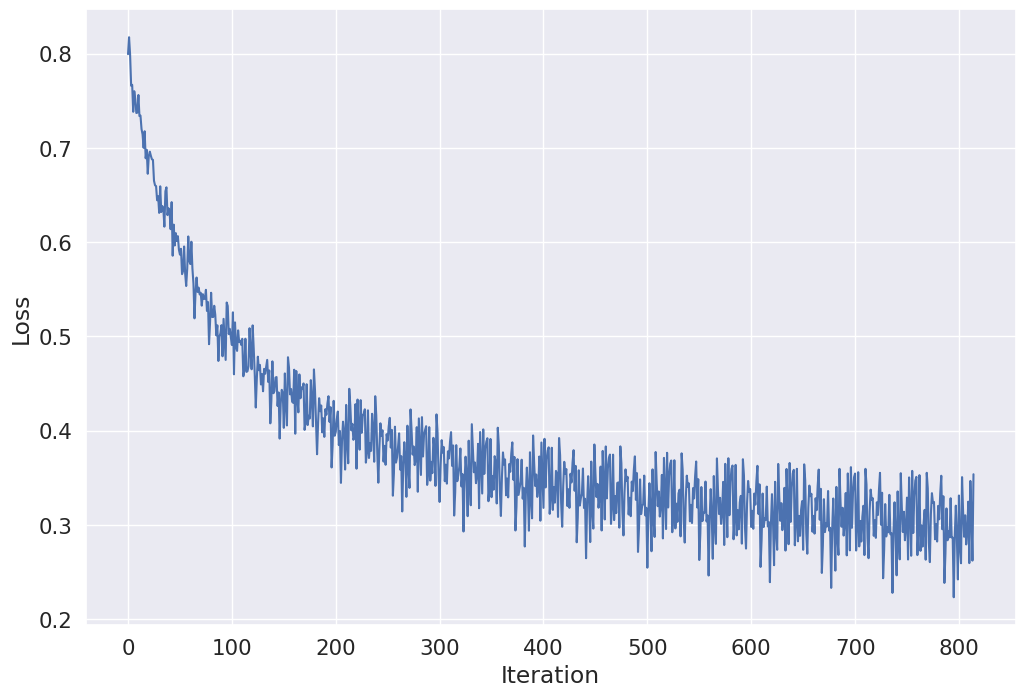

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

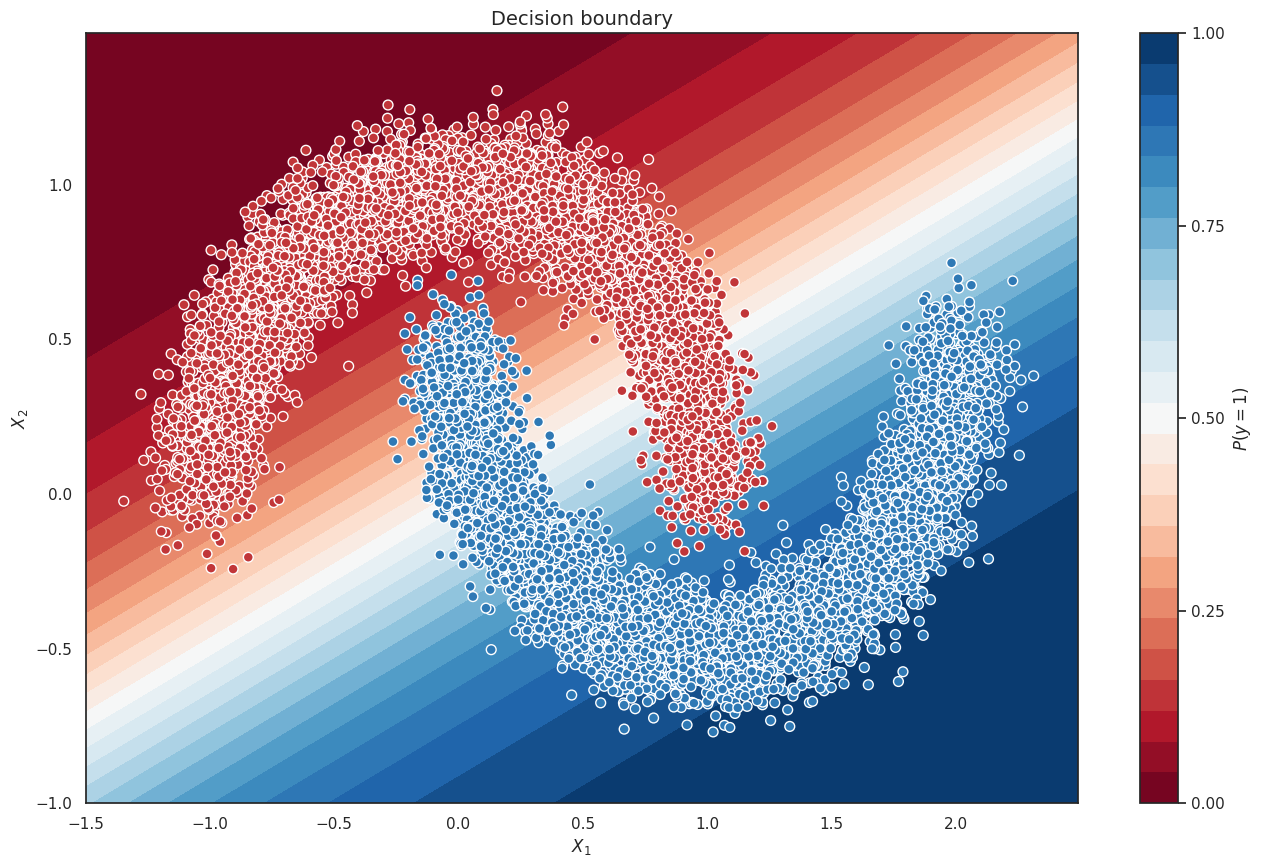

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        preds = (F.sigmoid(outp)>0.5)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, predict(val_dataloader,linear_regression))

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.862

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])


root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    activation,
    torch.nn.Linear(128, 128),
    activation,
    torch.nn.Linear(128, 10)
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch.to(device))
            else:
                 model.eval()
                 with torch.no_grad():
                  outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct =  (preds == y_batch.to(device)).sum()
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8902
Loader: valid. Accuracy: 0.9372
Epoch: 2
Loader: train. Accuracy: 0.94745
Loader: valid. Accuracy: 0.9553
Epoch: 3
Loader: train. Accuracy: 0.9627833333333333
Loader: valid. Accuracy: 0.9692
Epoch: 4
Loader: train. Accuracy: 0.97035
Loader: valid. Accuracy: 0.9688
Epoch: 5
Loader: train. Accuracy: 0.9750333333333333
Loader: valid. Accuracy: 0.9721
Epoch: 6
Loader: train. Accuracy: 0.9796166666666667
Loader: valid. Accuracy: 0.9754
Epoch: 7
Loader: train. Accuracy: 0.9805333333333334
Loader: valid. Accuracy: 0.9734
Epoch: 8
Loader: train. Accuracy: 0.9838333333333333
Loader: valid. Accuracy: 0.9736
Epoch: 9
Loader: train. Accuracy: 0.9850833333333333
Loader: valid. Accuracy: 0.9727
Epoch: 10
Loader: train. Accuracy: 0.98745
Loader: valid. Accuracy: 0.9733


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
def test_activation_function(activation):
  model = nn.Sequential(
    nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    activation,
    torch.nn.Linear(128, 128),
    activation,
    torch.nn.Linear(128, 10)).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())
  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0
      for x_batch, y_batch in dataloader:
        if k == "train":
          model.train()
          optimizer.zero_grad()
          outp = model(x_batch.to(device))
        else:
            model.eval()
            with torch.no_grad():
                outp = model(x_batch.to(device))
        preds = outp.argmax(-1)
        correct =  (preds == y_batch.to(device)).sum()
        all =  len(y_batch)
        epoch_correct += correct.item()
        epoch_all += all
        if k == "train":
          loss = criterion(outp, y_batch.to(device))
          loss.backward()
          optimizer.step()
      if k == "train":
        print(f"Epoch: {epoch+1}")
      print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
      accuracy[k].append(epoch_correct/epoch_all)
  return accuracy


In [ ]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.8747166666666667
Loader: valid. Accuracy: 0.9061
Epoch: 2
Loader: train. Accuracy: 0.90495
Loader: valid. Accuracy: 0.8954
Epoch: 3
Loader: train. Accuracy: 0.9059833333333334
Loader: valid. Accuracy: 0.9172
Epoch: 4
Loader: train. Accuracy: 0.9097333333333333
Loader: valid. Accuracy: 0.9078
Epoch: 5
Loader: train. Accuracy: 0.9115666666666666
Loader: valid. Accuracy: 0.9031
Epoch: 6
Loader: train. Accuracy: 0.9119333333333334
Loader: valid. Accuracy: 0.9071
Epoch: 7
Loader: train. Accuracy: 0.9146333333333333
Loader: valid. Accuracy: 0.9139
Epoch: 8
Loader: train. Accuracy: 0.9145333333333333
Loader: valid. Accuracy: 0.916
Epoch: 9
Loader: train. Accuracy: 0.9149
Loader: valid. Accuracy: 0.9191
Epoch: 10
Loader: train. Accuracy: 0.9155166666666666
Loader: valid. Accuracy: 0.9085
Epoch: 1
Loader: train. Accuracy: 0.8724
Loader: valid. Accuracy: 0.932
Epoch: 2
Loader: train. Accuracy: 0.9376
Loader: valid. Accuracy: 0.9521
Epoch: 3
Loader: train. Accu

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

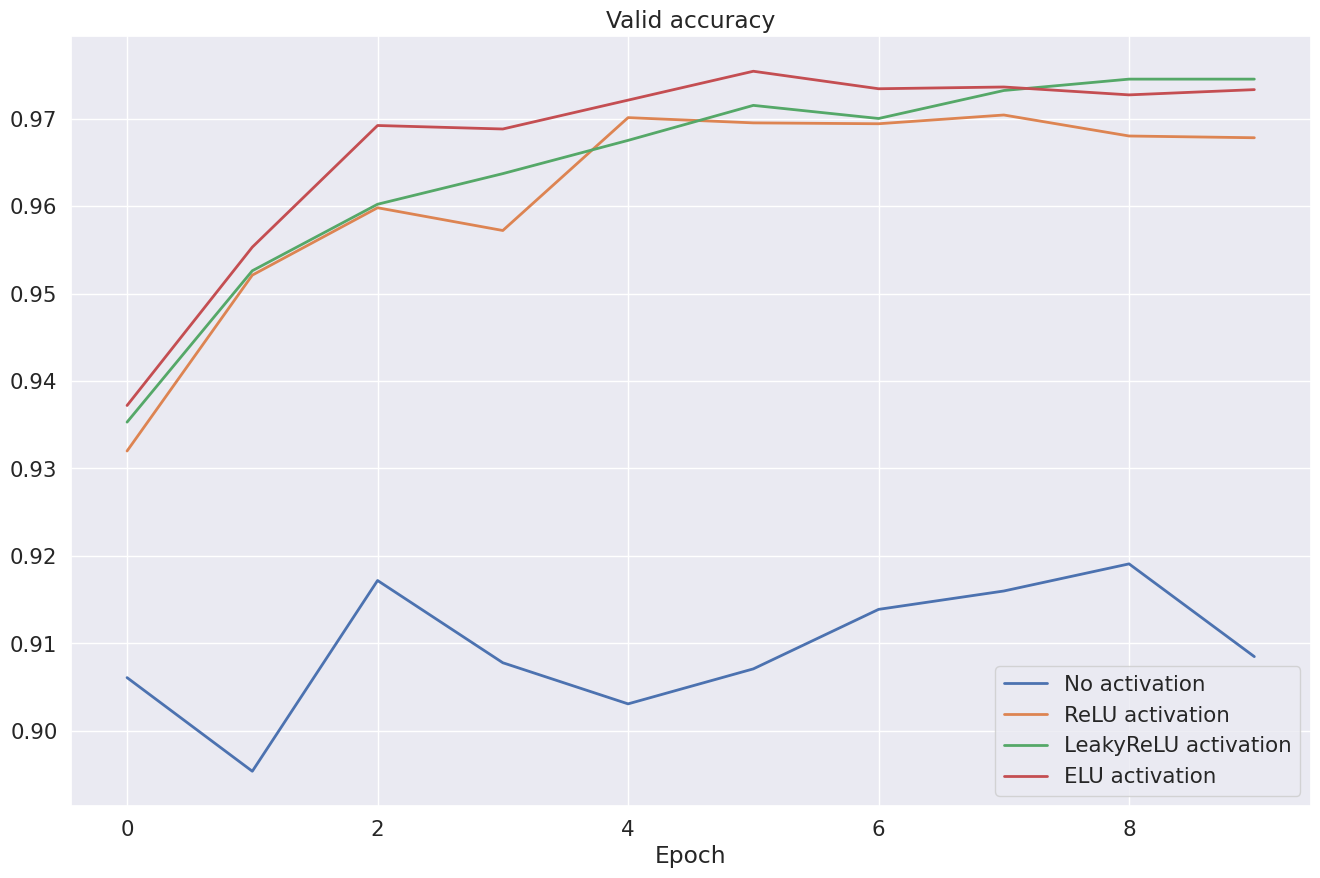

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy["valid"], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

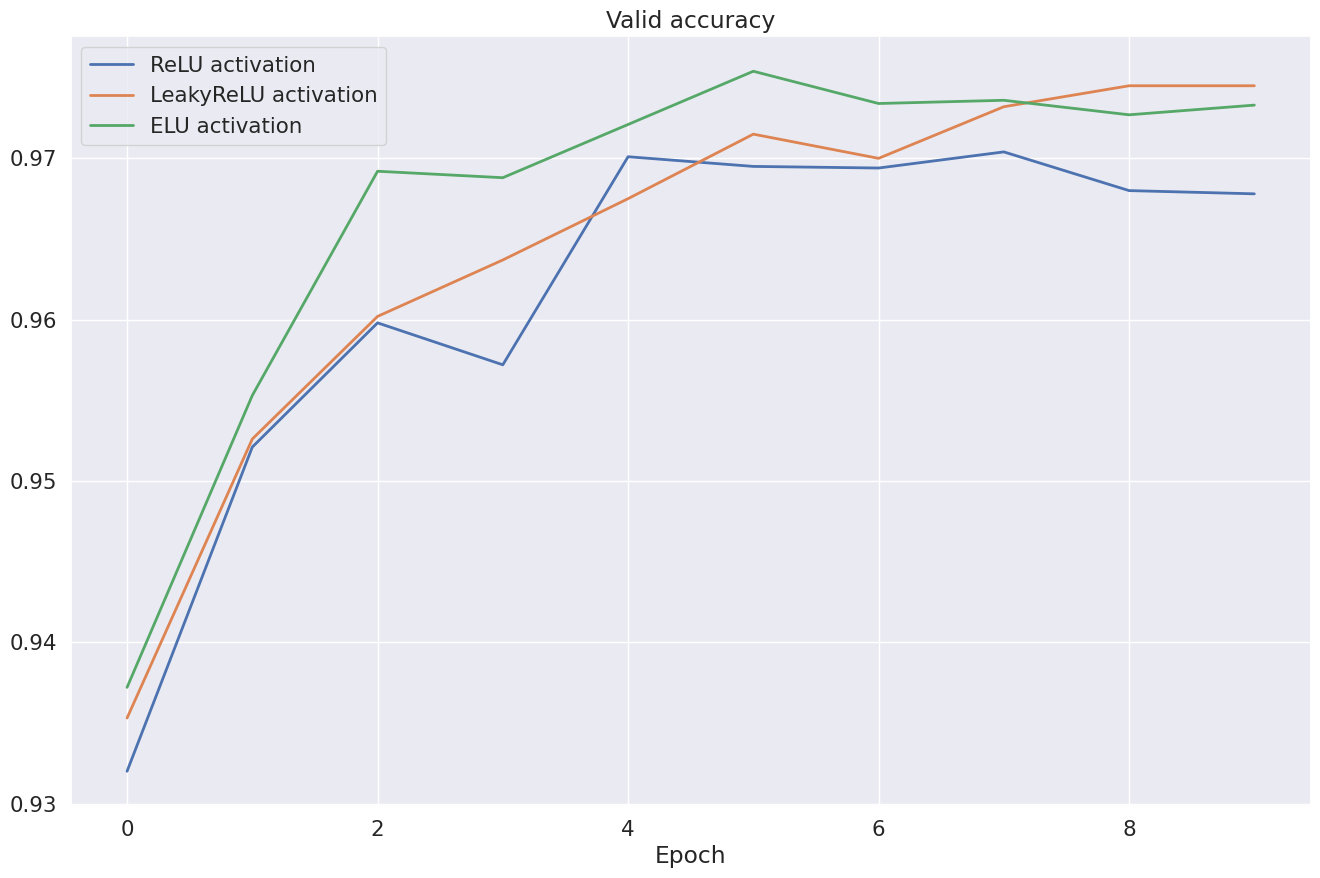

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyRelu

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      print(x.shape)
      x = x.view(-1, 4 * 4 * 16)  # !!!
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
  for k, dataloader in loaders.items():
    epoch_correct = 0
    epoch_all = 0
    for x_batch, y_batch in dataloader:
      if k == "train":
        model.train()
        optimizer.zero_grad()
        outp = model(x_batch.to(device))
      else:
          model.eval()
          with torch.no_grad():
              outp = model(x_batch.to(device))
      preds = outp.argmax(-1)
      correct =  (preds == y_batch.to(device)).sum()
      all =  len(y_batch)
      epoch_correct += correct.item()
      epoch_all += all
      if k == "train":
        loss = criterion(outp, y_batch.to(device))
        loss.backward()
        optimizer.step()
    if k == "train":
      print(f"Epoch: {epoch+1}")
    print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
    accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9173
Loader: valid. Accuracy: 0.9422
Epoch: 2
Loader: train. Accuracy: 0.95205
Loader: valid. Accuracy: 0.9602
Epoch: 3
Loader: train. Accuracy: 0.9654666666666667
Loader: valid. Accuracy: 0.965
Epoch: 4
Loader: train. Accuracy: 0.9718333333333333
Loader: valid. Accuracy: 0.966
Epoch: 5
Loader: train. Accuracy: 0.9764833333333334
Loader: valid. Accuracy: 0.9741
Epoch: 6
Loader: train. Accuracy: 0.9792666666666666
Loader: valid. Accuracy: 0.9731
Epoch: 7
Loader: train. Accuracy: 0.9822
Loader: valid. Accuracy: 0.9773
Epoch: 8
Loader: train. Accuracy: 0.9833833333333334
Loader: valid. Accuracy: 0.9752
Epoch: 9
Loader: train. Accuracy: 0.9859166666666667
Loader: valid. Accuracy: 0.9752
Epoch: 10
Loader: train. Accuracy: 0.9872333333333333
Loader: valid. Accuracy: 0.9782


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

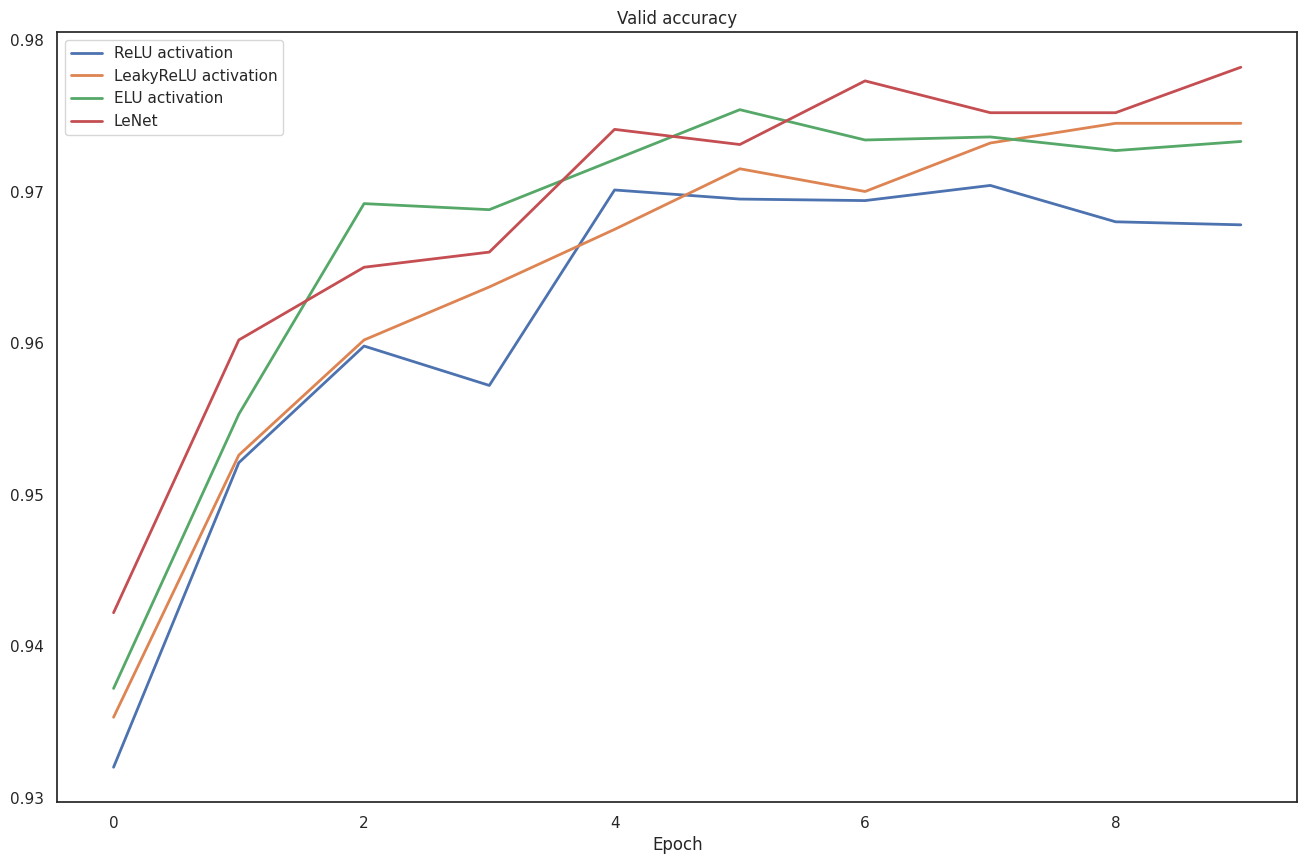

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98